# Task 4

#### Note
One thing which should be mentioned is the use of test set as validation set. It is written in the assignment, but I have tried to keep the terms correct concistently throughout the notebook.

Best practice is to hold out the test set and only use the term validation when talking about validating the model as it tunes its performance. The test set is then used to evaluate the model on a (hopefully) representative unseen dataset. 

As we are instructed to use the test set for both I will continue to do so, but try to be clear whether or not I use it as validation or test.

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import utils
import dataloaders
import torchvision
from trainer import Trainer

# Define output directories
output_dir = pathlib.Path("img/solutions")
output_dir.mkdir(exist_ok=True)
output_dir_weights = output_dir.joinpath("weights")
output_dir_weights.mkdir(exist_ok=True)

### Hyperparams and loss function


In [4]:
batch_size = 64
lr = 0.0192
epochs = 5

# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

### Models


In [5]:
# Reset seeds for each model
def reset_seeds():
    torch.random.manual_seed(0)
    np.random.seed(0)

def create_single_layer_model():
    reset_seeds()
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28*1, 10)
    )
    return utils.to_cuda(model)

def create_multi_layer_model():
    reset_seeds()
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28*1, 64),
        nn.ReLU(),
        nn.Linear(64, 10)   
    )
    return utils.to_cuda(model)


## Base


Output shape: torch.Size([64, 10])


Training epoch 4: 100%|██████████| 938/938 [00:01<00:00, 536.20it/s]


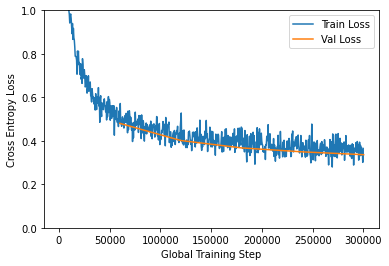

Final Test loss: 0.33621848246474173. Final Test accuracy: 0.9083


In [6]:
# Load data
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

model = create_single_layer_model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Test if the model is able to do a single forward pass
example_images, _ = utils.to_cuda(next(iter(dataloader_train)))
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

# Train
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(epochs)

# Plot loss
utils.plot_loss(train_loss_dict,
                label="Train Loss")
utils.plot_loss(val_loss_dict,
                label="Val Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")


## Task A
*Normalize dataset and plot the graph containing both models' loss*

Training epoch 4: 100%|██████████| 938/938 [00:02<00:00, 419.08it/s]


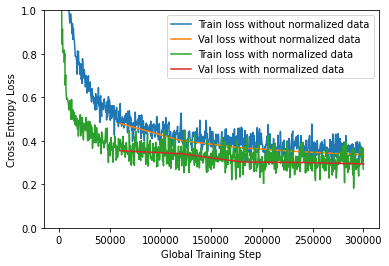

Final Test loss: 0.2939883841284711. Final Test accuracy: 0.9164


In [7]:
# Normalize dataset and load it
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.5, std=0.5)
])
dataloader_train, dataloader_val = dataloaders.load_dataset(batch_size, image_transform)

model = create_single_layer_model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_val,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict_normalized, val_loss_dict_normalized = trainer.train(epochs)


# Plot loss
utils.plot_loss(train_loss_dict,
                label="Train loss without normalized data")
utils.plot_loss(val_loss_dict,
                label="Val loss without normalized data")
utils.plot_loss(train_loss_dict_normalized,
                label="Train loss with normalized data")
utils.plot_loss(val_loss_dict_normalized,
                label="Val loss with normalized data")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath("task4_a"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")



## Task B
*Plot the weights*

In [8]:
weight_image_array = np.zeros(shape=(28, 28))
weight_tensors = list(model.children())[1].weight.cpu().data

# Target class is 0-9, and each corresponds to weight_tensors[target]
for target, tensor in enumerate(weight_tensors):
    # Each tensor has length 28x28
    for i, value in enumerate(tensor):
        weight_image_array[i // 28, i % 28] = value

    utils.save_im(output_dir_weights.joinpath(f"weight_{target}.jpg"), weight_image_array)

## Task C
*Increase learning rate, plot and compare to earlier model*

Training epoch 4: 100%|██████████| 938/938 [00:02<00:00, 416.39it/s]


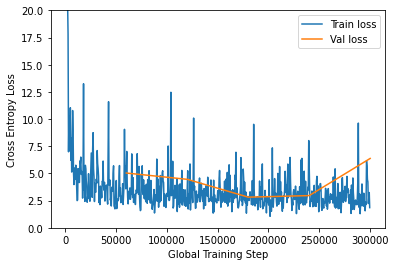

Final Test loss: 6.378498098652834. Final Test accuracy: 0.7807


In [9]:
model = create_single_layer_model()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

# Train
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_val,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(epochs)


# Plot loss
utils.plot_loss(train_loss_dict,
                label="Train loss")
utils.plot_loss(val_loss_dict,
                label="Val loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 20])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath("task4_c"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")


## Task D
*Include a hidden layer with 64 nodes, with ReLU as activation function for first layer*

Training epoch 4: 100%|██████████| 938/938 [00:02<00:00, 398.26it/s]


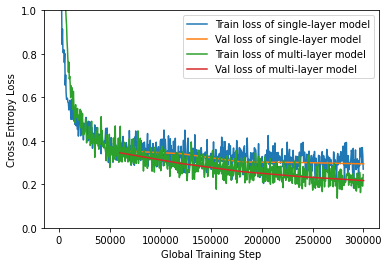

Final Test loss: 0.21728393818091624. Final Test accuracy: 0.9369


In [10]:
model = create_multi_layer_model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_val,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(epochs)

# Plot loss with [train/test]_loss_dict_normalized from task a
utils.plot_loss(train_loss_dict_normalized,
                label="Train loss of single-layer model")
utils.plot_loss(val_loss_dict_normalized,
                label="Val loss of single-layer model")
utils.plot_loss(train_loss_dict,
                label="Train loss of multi-layer model")
utils.plot_loss(val_loss_dict,
                label="Val loss of multi-layer model")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(output_dir.joinpath("task4_d"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

